<a href="https://colab.research.google.com/github/Tarif-dev/ecg-ssl-research/blob/main/notebooks/01_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Notebook 01: Data Download & Exploration

**Goal:** Download the MIT-BIH Arrhythmia Database, explore its structure, and visualize raw ECG signals.

**Steps:**
1. Install dependencies & mount Google Drive
2. Clone/setup the project repository
3. Download the MIT-BIH dataset from PhysioNet
4. Explore: load records, inspect annotations
5. Visualize ECG signals and beat distributions

In [1]:
# ============================================================
# STEP 1: Install dependencies & mount Google Drive
# ============================================================
# Run this cell first every time you open this notebook in Colab

# Install required packages
!pip install -q wfdb numpy scipy matplotlib scikit-learn pyyaml tqdm wandb seaborn

# Mount Google Drive (for persistent storage across sessions)
from google.colab import drive
drive.mount('/content/drive')

# Create project directory on Drive (persistent)
import os
PROJECT_DIR = '/content/drive/MyDrive/ecg_ssl_research'
DATA_DIR = os.path.join(PROJECT_DIR, 'data', 'raw', 'mitdb')
os.makedirs(DATA_DIR, exist_ok=True)
print(f"✓ Project directory: {PROJECT_DIR}")
print(f"✓ Data directory: {DATA_DIR}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.9/163.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 35.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 3.0.0 which is incompatible.
gradio 5.50.0 requires pandas<3.0,>=1.0, but you have pandas 3.0.0 which is incompatible.
bqplot 0.12.45 requires pandas<3.0.0,>=1.0.0, but you have pandas 3.0.0 which is incompatible.
db-dtypes 1.5.0 requires pandas<3.0.0,>=1.5.3, but you have pandas 3.0.0 which is incompatible.
Mounted at /content/drive
✓ Project directory: /content/drive/MyDrive/ecg_ssl_research
✓ Data directory: /content/drive/MyDrive/ecg_ssl_research/data/raw/mitdb


In [2]:
# ============================================================
# STEP 2: Clone the repo & set up imports
# ============================================================
# Clone your GitHub repo (replace with YOUR repo URL)
REPO_URL = "https://github.com/Tarif-dev/ecg-ssl-research.git"  # <-- CHANGE THIS
REPO_DIR = '/content/ecg-ssl-research'

if not os.path.exists(REPO_DIR):
    !git clone {REPO_URL} {REPO_DIR}
    print("✓ Repository cloned!")
else:
    # Pull latest changes if repo already exists
    !cd {REPO_DIR} && git pull
    print("✓ Repository updated!")

# Add project to Python path so we can import our modules
import sys
sys.path.insert(0, REPO_DIR)

# Now we can import our custom modules
from src.download_data import (
    download_mitbih, load_record, extract_beats,
    extract_segments, verify_download, MITBIH_RECORDS, BEAT_LABELS_BINARY
)
from src.utils import set_seed

set_seed(42)
print("✓ All imports ready!")

Cloning into '/content/ecg-ssl-research'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (26/26), done.
Receiving objects: 100% (35/35), 29.28 KiB | 516.00 KiB/s, done.
remote: Total 35 (delta 1), reused 35 (delta 1), pack-reused 0 (from 0)
Resolving deltas: 100% (1/1), done.
✓ Repository cloned!
Random seed set to 42
✓ All imports ready!


In [3]:
# ============================================================
# STEP 3: Download MIT-BIH Arrhythmia Database
# ============================================================
# This downloads 48 ECG recordings from PhysioNet (~115 MB)
# It's saved to Google Drive so you only need to do this ONCE

if not os.path.exists(os.path.join(DATA_DIR, '100.dat')):
    print("Downloading MIT-BIH database (this takes ~2-5 minutes)...\n")
    download_mitbih(DATA_DIR)
else:
    print("✓ MIT-BIH data already downloaded!")
    verify_download(DATA_DIR)


This may take a few minutes depending on your connection.

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating r

In [4]:
# ============================================================
# STEP 4: Explore the data — load a record & inspect
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

# Load record 100 (first record in the database)
record_path = os.path.join(DATA_DIR, '100')
signal, annotation, fs = load_record(record_path, channel=0)

print(f"Record: 100")
print(f"  Signal shape: {signal.shape}")
print(f"  Sampling rate: {fs} Hz")
print(f"  Duration: {len(signal)/fs:.1f} seconds ({len(signal)/fs/60:.1f} minutes)")
print(f"  Signal range: [{signal.min():.3f}, {signal.max():.3f}]")
print(f"  Number of annotations: {len(annotation.symbol)}")
print(f"  Unique beat types: {sorted(set(annotation.symbol))}")

# Count beat types in this record
from collections import Counter
beat_counts = Counter(annotation.symbol)
print(f"\n  Beat distribution:")
for symbol, count in beat_counts.most_common():
    label = "Normal" if symbol in ('N','L','R','e','j') else "Abnormal" if symbol in BEAT_LABELS_BINARY else "Non-beat"
    print(f"    {symbol}: {count:5d} ({label})")

Record: 100
  Signal shape: (650000,)
  Sampling rate: 360 Hz
  Duration: 1805.6 seconds (30.1 minutes)
  Signal range: [-2.715, 1.435]
  Number of annotations: 2274
  Unique beat types: ['+', 'A', 'N', 'V']

  Beat distribution:
    N:  2239 (Normal)
    A:    33 (Abnormal)
    +:     1 (Non-beat)
    V:     1 (Abnormal)


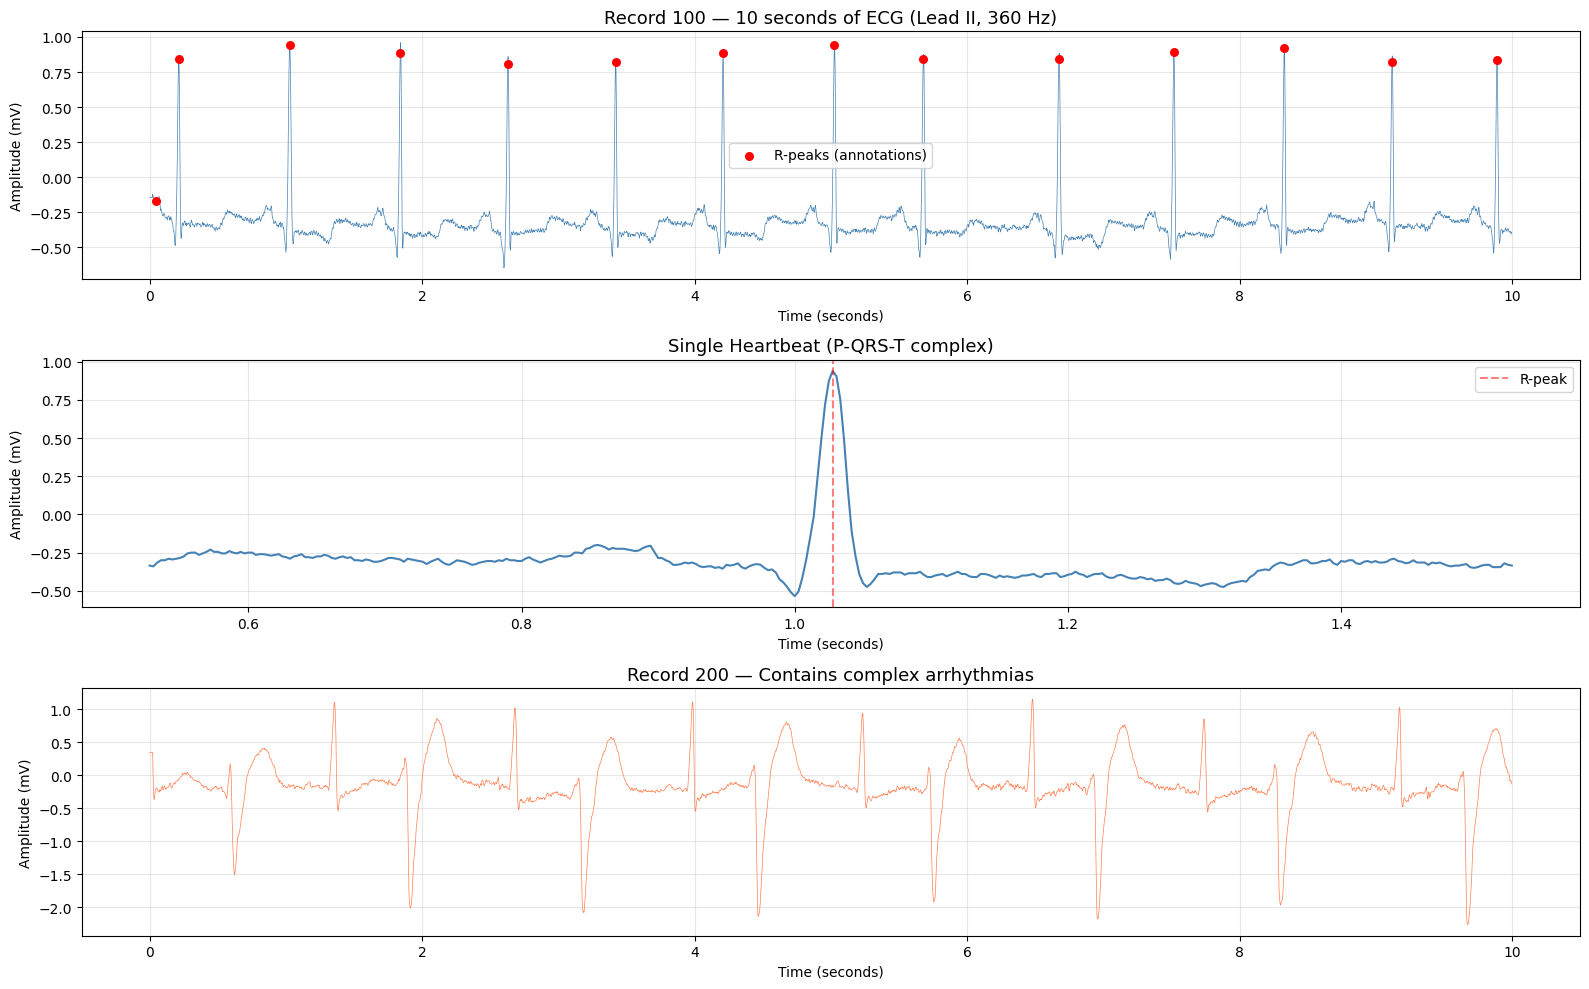

✓ Figure saved!


In [5]:
# ============================================================
# STEP 5: Visualize raw ECG signals
# ============================================================

fig, axes = plt.subplots(3, 1, figsize=(16, 10))

# Plot 1: Full 10-second segment
start = 0
duration_sec = 10
end = start + int(duration_sec * fs)
time_axis = np.arange(start, end) / fs

axes[0].plot(time_axis, signal[start:end], color='steelblue', linewidth=0.5)
axes[0].set_title(f'Record 100 — 10 seconds of ECG (Lead II, {fs} Hz)', fontsize=13)
axes[0].set_xlabel('Time (seconds)')
axes[0].set_ylabel('Amplitude (mV)')
axes[0].grid(True, alpha=0.3)

# Mark R-peaks in this window
r_peaks_in_window = annotation.sample[(annotation.sample >= start) & (annotation.sample < end)]
axes[0].scatter(r_peaks_in_window / fs, signal[r_peaks_in_window],
                color='red', s=30, zorder=5, label='R-peaks (annotations)')
axes[0].legend()

# Plot 2: Zoom into a single heartbeat (~1 second)
beat_center = r_peaks_in_window[2]  # Third beat
window = int(0.5 * fs)  # 0.5s before and after
beat_start = max(0, beat_center - window)
beat_end = min(len(signal), beat_center + window)
beat_time = np.arange(beat_start, beat_end) / fs

axes[1].plot(beat_time, signal[beat_start:beat_end], color='steelblue', linewidth=1.5)
axes[1].axvline(x=beat_center/fs, color='red', linestyle='--', alpha=0.5, label='R-peak')
axes[1].set_title('Single Heartbeat (P-QRS-T complex)', fontsize=13)
axes[1].set_xlabel('Time (seconds)')
axes[1].set_ylabel('Amplitude (mV)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Load a record with arrhythmias (record 200)
sig200, ann200, fs200 = load_record(os.path.join(DATA_DIR, '200'), channel=0)
start200 = 0
end200 = int(10 * fs200)
t200 = np.arange(start200, end200) / fs200

axes[2].plot(t200, sig200[start200:end200], color='coral', linewidth=0.5)
axes[2].set_title('Record 200 — Contains complex arrhythmias', fontsize=13)
axes[2].set_xlabel('Time (seconds)')
axes[2].set_ylabel('Amplitude (mV)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_DIR, 'ecg_exploration.png'), dpi=150, bbox_inches='tight')
plt.show()
print("✓ Figure saved!")

Successfully loaded 48/48 records

Total beats (classifiable): 109,494
  Normal:    90,631 (82.8%)
  Abnormal:  18,863 (17.2%)


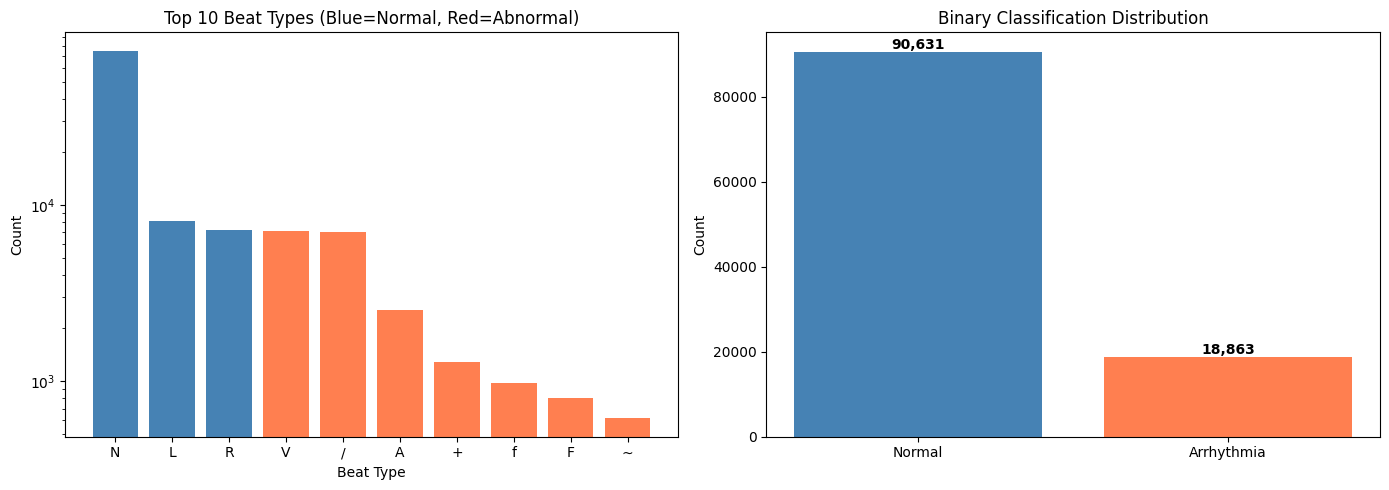


✓ Exploration complete! Proceed to Notebook 02 for preprocessing.


In [6]:
# ============================================================
# STEP 6: Analyze ALL records — beat distribution across dataset
# ============================================================
import seaborn as sns

all_beat_counts = Counter()
records_info = []

for rec_id in MITBIH_RECORDS:
    try:
        rec_path = os.path.join(DATA_DIR, str(rec_id))
        sig, ann, rec_fs = load_record(rec_path, channel=0)

        rec_beats = Counter(ann.symbol)
        all_beat_counts.update(rec_beats)

        # Count normal vs abnormal
        n_normal = sum(rec_beats.get(s, 0) for s in ('N','L','R','e','j'))
        n_abnormal = sum(rec_beats.get(s, 0) for s in BEAT_LABELS_BINARY if BEAT_LABELS_BINARY[s] == 1)
        records_info.append({
            'record': rec_id, 'duration_min': len(sig)/rec_fs/60,
            'total_beats': len(ann.symbol), 'normal': n_normal, 'abnormal': n_abnormal
        })
    except Exception as e:
        print(f"  ⚠ Record {rec_id}: {e}")

print(f"Successfully loaded {len(records_info)}/{len(MITBIH_RECORDS)} records\n")

# Overall statistics
total_normal = sum(r['normal'] for r in records_info)
total_abnormal = sum(r['abnormal'] for r in records_info)
total_beats = total_normal + total_abnormal
print(f"Total beats (classifiable): {total_beats:,}")
print(f"  Normal:   {total_normal:>7,} ({100*total_normal/total_beats:.1f}%)")
print(f"  Abnormal: {total_abnormal:>7,} ({100*total_abnormal/total_beats:.1f}%)")

# Bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Beat type distribution
labels_sorted = all_beat_counts.most_common(10)
syms, counts = zip(*labels_sorted)
colors = ['steelblue' if s in ('N','L','R','e','j') else 'coral' for s in syms]
axes[0].bar(syms, counts, color=colors)
axes[0].set_title('Top 10 Beat Types (Blue=Normal, Red=Abnormal)')
axes[0].set_xlabel('Beat Type')
axes[0].set_ylabel('Count')
axes[0].set_yscale('log')

# Binary class distribution
axes[1].bar(['Normal', 'Arrhythmia'], [total_normal, total_abnormal],
            color=['steelblue', 'coral'])
axes[1].set_title('Binary Classification Distribution')
axes[1].set_ylabel('Count')
for i, v in enumerate([total_normal, total_abnormal]):
    axes[1].text(i, v + 500, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_DIR, 'beat_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Exploration complete! Proceed to Notebook 02 for preprocessing.")